In [97]:
from pfs.lam.detAnalysis import *
from pfs.lam.detFocusAnalysis import *
from pfs.lam.fileHandling import *
from pfs.lam.style import *
import glob
import lsst.daf.persistence as dafPersist

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [99]:
from sklearn.ensemble import IsolationForest

In [100]:
#invMat = "/home/fmadec/devel/ait-notebook/fmadec/Subaru/SM1/SM1_R1_DetFocusInvMat_20190423_F2.8.mat"
invMat="InvMat_sm1_B1_02oct2020.mat"
#invMat = "SM1_B1_DetFocusInvMat_20190305_bundlesBGR3R6.mat"

In [101]:
def getFocusMap(fitdata, index='relPos', criterias=['EE5','EE3', 'brightness', 'fwhm']): 
    data = []
    for (peak, fiber), series in fitdata.groupby(['peak','fiber']):
        #series = series.dropna()
        wavelength = series.wavelength.unique()[0]
        for criteria in criterias:
            if ('fwhm' in criteria) or ('2ndM' in criteria) :
                ixmax = series[criteria].idxmin()
                value = series[criteria].min()
            else:
                ixmax = series[criteria].idxmax()
                value = series[criteria].max()
            focus = series[index][ixmax]
            px = series.px[ixmax]
            py = series.py[ixmax]
            mat = [peak,wavelength,fiber,criteria, px, py, focus, focus+series.motor1.min(), focus+series.motor2.min(), focus+series.motor3.min(), value]
            data.append(tuple(mat))
    
    columns = ['peak','wavelength', 'fiber', 'criteria', 'px', 'py', 'relPos', 'motor1', 'motor2', 'motor3', 'value']
    return pd.DataFrame(data, columns=columns)

In [102]:
def plot_one_group(piston_imdata, wave, fiber, exp, plot_path, criteria="EE5", doSave=False) :
    group = piston_imdata.groupby(['wavelength','fiber']).get_group((wave,fiber))
    
    ax = group.plot.scatter("motor1", "EE5",\
                        title=f"Exp{experimentId} - fiber {fiber} - wave {wave}",\
                       label="EE5")
#    ax2 = ax.twinx()
#    group.plot.scatter("motor1", "sep_x2", ax=ax,color="r", label="sep_x2" )
#    group.plot.scatter("motor1", "sep_y2", ax=ax2,color="g", label="sep_y2" )
#    group.plot.scatter("motor1", "sep_ECE5", ax=ax2,color="y", label="sep ECE5" )

    #fig.patch.set_alpha(0.5)
    dat = datetime.now().isoformat(timespec='minutes') 
    if doSave : 
        plt.savefig(plot_path+f"Focus_fit_fiber{fiber}_wave{wave}_Exp{exp}_{dat}.png")
    plt.show()

In [103]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False

In [128]:
def plot_groups(piston_imdata, exp, plot_path, plot_prefix="Focus_Piston_plots", title_suffix=None, col="fiber", hue="wavelength", criteria="EE5", doSave=False) :
    grid = sns.FacetGrid(piston_imdata, col=col, hue=hue,
#                         col_wrap=4, height=3, legend_out=True)
                         col_wrap=3, height=3, legend_out=True)

    grid.map(plt.plot, "motor1", criteria, marker="+")
    grid.fig.tight_layout(w_pad=1)
    if criteria == "EE5":
        grid.set(ylim=(0, 1))
    grid.add_legend()
    plt.subplots_adjust(top=0.75)
    if title_suffix is None:
        title = f"{plot_prefix} - Exp{experimentId}"
    else: 
        title = f"{plot_prefix} - Exp{experimentId}\n{title_suffix}"
    grid.fig.suptitle(title)
    dat = datetime.now().isoformat(timespec='minutes') 
    if doSave:
        plt.savefig(plot_path+f"{plot_prefix}_{col}_{hue}_Exp{exp}_{dat}.png")
    plt.show()

In [ ]:
100*(r1/r)

In [ ]:
experimentId = 255
rerun = "sm1-march2020" #"sm1-march2020"
cam = "m1"
#thres_neighbor = -0.05
extra = 'stack/'

In [ ]:
experimentId = 186
rerun = "sm1-march2020-no_FD" #"sm1-march2020"
cam = "r1"
extra = ''

In [9]:
experimentId = 122
rerun = "dcb2" #"sm1-march2020"
cam = "b2"
extra = ''

In [143]:
experimentId = 124
rerun = "defocus" #"sm1-march2020"
cam = "b2"
extra = ''

In [144]:
roi_size = 24
doBck = True
threshold = 0.

In [145]:
head = 0
tail = 0

In [146]:
cluster = False

In [147]:
doForestFilter = False
forest_contamin = 0.05   #r1 0.05   #m1 

In [148]:
doNeighborFilter = True
thres_neighbor = -0.1

In [149]:
doSave = True
doSaveCsv = False

In [155]:
if cluster :
    imgPath = '/net/SRVSTK20C/drp/fmadec/analysis/subaru/sm1/'
    dataPath = "/net/SRVSTK20C/drp/fmadec/analysis/subaru/sm1/"
    drpPath = "/net/SRVSTK20C/drp/cluster"
    repo = "repo"
else:
    imgPath = "/media/fmadec/PfsData/PFS/fmadec/analysis/subaru/sm1/"
    #imgPath = '/home/fmadec/Pictures/analysis/'
    dataPath = imgPath
    drpPath = "/home/fmadec/pfs/subaruData/"    
    repo = "drp"

if False:
    imgPath = "/home/fmadec/Pictures/analysis/"
    #imgPath = '/home/fmadec/Pictures/analysis/'
    dataPath = imgPath
    drpPath = "/home/fmadec/pfs/subaruData/"    
    repo = "drp"
 #   Exp255/sm1-march2020_roi24/doBckTrue/stack
    
if True:
    imgPath = '/drp/analysis/sm2/'
    #imgPath = '/home/fmadec/Pictures/analysis/'
    dataPath = imgPath
    drpPath = "/drp"    
    repo = "sps"
 #   Exp255/sm1-march2020_roi24/doBckTrue/stack

outpath = ''


if False:
    outpath = ''
    try:
        opts, args = getopt.getopt(argv,"hc:o:r:b:e:",["cam=", "outpath=", "rerun=", "doBck=", "exp="])
    except getopt.GetoptError:
        print('Cluster_GetBestPlanefromCsv.py -v <visit> -p <peakfile> -c <cam> -r <rerun>')
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print('Cluster_GetBestPlanefromCsv.py -v <visit> -p <peakfile> -c <cam>')
            sys.exit()
        elif opt in ("-e", "--exp"):
            experimentId = int(arg)
        elif opt in ("-c", "--cam"):
            cam = arg
        elif opt in ("-o", "--outpath"):
            outpath = arg
        elif opt in ("-r", "--rerun"):
            rerun = arg
        elif opt in ("-b", "--doBck"):
            doBck = str2bool(arg)


piston_index = "motor1"


outpath = "output\\" if outpath is None else outpath

# define defaut parameters
roi_size = 24
com = True  # Center Of Mass
head = 0
tail = 0
criteria = 'EE5'
criterias = [criteria] #['EE5', 'sep_ECE5']
verbose = True
doPrint = False
arm = cam[0]



csvPath = imgPath+"Exp"+str(experimentId)+"/"+rerun+"_roi"+str(roi_size)+"/doBck"+str(doBck)+"/"+extra
dataPath = csvPath
print(dataPath)

searchFile = f"{csvPath}Imquality_{cam}_Exp{experimentId}*"
print(searchFile)
files = glob.glob(searchFile)

if verbose:
    print(*files, sep="\n")

piston_imdata = pd.concat(map(pd.read_csv,files)).reset_index().sort_values(by="motor1")
#piston_imdata["wavelength"] = 300

piston_imdata = piston_imdata.groupby(['wavelength','fiber', "motor1"]).mean().reset_index()

# hack debut sm2


print(f"Wavelength used: {piston_imdata.wavelength.unique()}")
minPos = piston_imdata[['motor1','motor2','motor3']]
minPos = minPos - minPos.min()
piston_imdata['relPos'] = minPos['motor1']

#piston = piston_imdata[piston_imdata.EE5>threshold]

piston_imdata["fit_flag"] = 0
piston_imdata["EE5_diff_flag"] = True

piston = piston_imdata

#piston = piston_imdata[piston_imdata.EE5>threshold]

if doForestFilter :
    tot = []
#    for  group_name, series in piston_imdata.groupby(['wavelength','fiber']):
    for  group_name, series in piston.groupby(['wavelength','fiber']):

        #clf = IsolationForest( behaviour = 'new', max_samples=series.count()[0], random_state = 1, contamination= "auto")
        clf = IsolationForest( behaviour = 'new', max_samples=series.count()[0], random_state = 1, contamination= forest_contamin)

        preds = clf.fit_predict(series[[piston_index, "EE5"]].values)
        series.loc[:,"fit_flag"] = preds
        tot.append(series)
        piston = pd.concat(tot)

if doNeighborFilter :
    tot = []
#    for  group_name, series in piston_imdata.groupby(['wavelength','fiber']):
    for  group_name, series in piston.groupby(['wavelength','fiber']):
        #clf = IsolationForest( behaviour = 'new', max_samples=series.count()[0], random_state = 1, contamination= "auto")
        #series["EE5_diff"] = (series.EE5.pct_change(periods=-1).abs() - series.EE5.pct_change(periods=1).abs())
        #series["EE5_diff_flag"] = (series.EE5.pct_change(periods=-1).abs() - series.EE5.pct_change(periods=1).abs() < thres_neighbor)
        #series["EE5_diff"] = (series.EE5.diff(-1) + series.EE5.diff(2) - series.EE5.diff(1))/2. 
        series["EE5_diff"] = series.EE5 - (series.EE5.shift(-1) + series.EE5.shift(1))/2 

        series["EE5_diff"].fillna(0, inplace=True)
        series["EE5_diff_flag"] = (series.EE5_diff> thres_neighbor)
        tot.append(series)
        piston = pd.concat(tot)
        



forest_prefix = "_Forest" if doForestFilter else ""

piston_fitdata = fitFocusData(piston[piston.EE5_diff_flag] , index=piston_index, doPlot=False, criterias=criterias, head=head )

piston_focusMap = getFocusMap(piston_fitdata.dropna(), index=piston_index, criterias=criterias)

piston_focusMap["experimentId"] = experimentId

if doSaveCsv:
    piston_fitdata.to_csv(f"{csvPath}imquality_{cam}_Exp{experimentId}_doBck{str(doBck)}_piston_fitdata_thres{str(int(threshold*100)).zfill(3)}{forest_prefix}.csv")
    piston_focusMap.to_csv(f"{csvPath}imquality_{cam}_Exp{experimentId}_doBck{str(doBck)}_piston_focusMap_thres{str(int(threshold*100)).zfill(3)}{forest_prefix}.csv")

piston["x2+y2/2"] = (piston.sep_x2 + piston.sep_y2)/2

/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124*
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23790_20201215T17h45.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23781_20201215T17h43.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23779_20201215T17h43.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23786_20201215T17h44.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23792_20201215T17h45.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23783_20201215T17h44.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23788_20201215T17h44.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23784_20201215T17h44.csv
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/Imquality_b2_Exp124_23777_20201215T17h43.csv
/drp/analysis/sm2/Exp124/defocus_r

/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [156]:
piston_imdata["sep_2ndM"]= piston_imdata.apply(lambda x: np.mean([x["sep_x2"],x["sep_y2"]]) , axis=1)

In [157]:
piston[piston.fit_flag >=0 & piston.EE5_diff_flag].motor1.min()

9.99

In [158]:
piston_fitdata.motor1.min()

9.99

[  2 315 650] [650.8325]


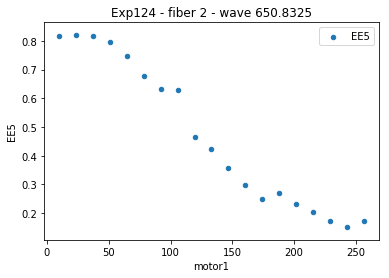

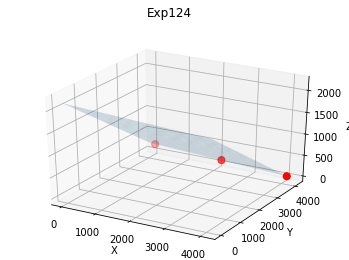

2020-12-15 17:45:55.414721 
/drp/analysis/sm2/Exp124/defocus_roi24/doBckTrue/
ExpId 124
InvMat_sm1_B1_02oct2020.mat
[1144.39124406   68.63405928 1990.45507138]
xcu_b2 motors moveCcd a=1144.39 b=68.63 c=1990.46 microns abs



/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


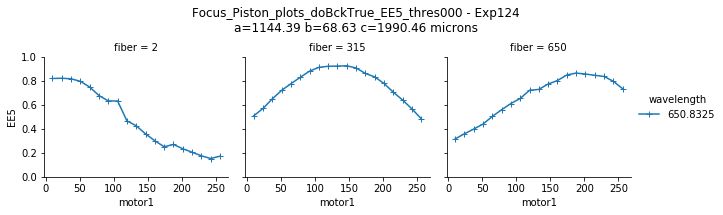

/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


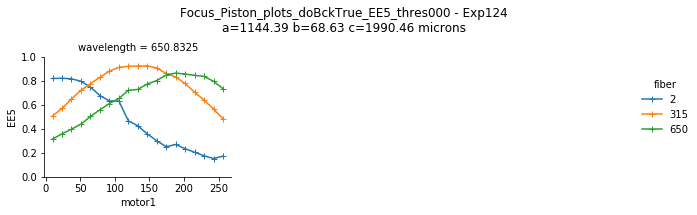

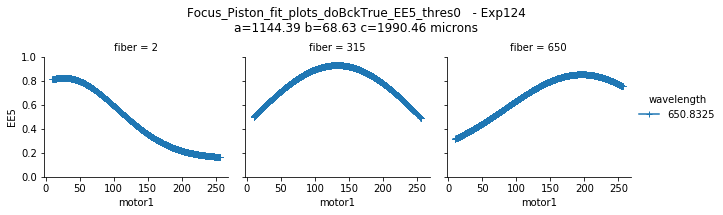

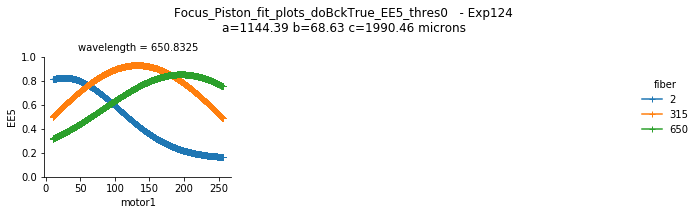

In [159]:
waves = piston_fitdata.wavelength.unique()
fibers = piston_fitdata.fiber.unique()
print(fibers, waves)
fiber = fibers[0]
wave = waves[0]
#    group = piston_imdata.groupby(['wavelength','fiber']).get_group((wave,fiber))
plot_one_group(piston, wave, fiber, experimentId, dataPath)

piston_plane = getBestPlane(piston_focusMap.query("criteria == '%s'"%criteria),order=1, \
                        doPlot=True, exp=experimentId, plot_path=dataPath)


txtfile = f"SM1_{cam.upper()}_BestFocusPlane_Exp{experimentId}_doBck{str(doBck)}_{criteria}_thres{str(int(threshold*100)).zfill(3)}{forest_prefix}.dat"

foc = findMotorPos(piston_plane, inv_mat = invMat)

txt = f"{datetime.now()} \n"
txt += f"{csvPath}\n"
txt += f"ExpId {experimentId}\n"
txt += f"{invMat}\n"
txt += f"{foc}\n"
txt += f"xcu_{cam} motors moveCcd a={foc[0]:.2f} b={foc[1]:.2f} c={foc[2]:.2f} microns abs\n"

print(txt)

if doSave :
    text_file = open(csvPath+txtfile, "w")
    text_file.write(txt)
    text_file.close()

plot_prefix = f"Focus_Piston_plots_doBck{str(doBck)}_{criteria}_thres{str(int(threshold*100)).zfill(3)}{forest_prefix}"
title_suffix = f"a={foc[0]:.2f} b={foc[1]:.2f} c={foc[2]:.2f} microns"
plot_groups(piston.sort_values("motor1")[piston.EE5_diff_flag], experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="fiber", hue="wavelength", criteria=criteria, doSave=doSave)
plot_groups(piston.sort_values("motor1")[piston.EE5_diff_flag], experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="wavelength", hue="fiber", criteria=criteria, doSave=doSave)

plot_prefix = f"Focus_Piston_fit_plots_doBck{str(doBck)}_{criteria}_thres{int(threshold*100):<3}{forest_prefix}"
plot_groups(piston_fitdata.sort_values("motor1"), experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix, \
            col="fiber", hue="wavelength", criteria=criteria, doSave=doSave)
plot_groups(piston_fitdata.sort_values("motor1"), experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="wavelength", hue="fiber", criteria=criteria, doSave=doSave)

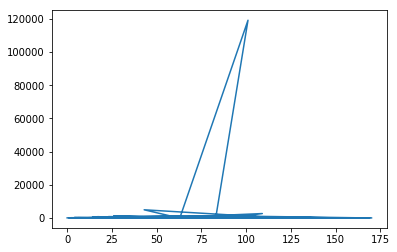

In [142]:
piston.sort_values("motor1")["fwhm"].plot()

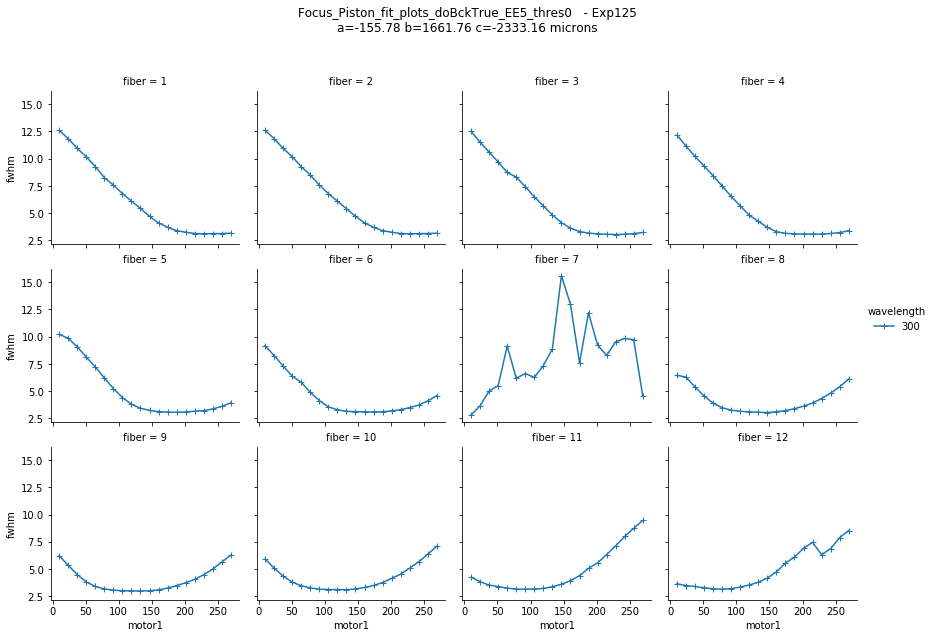

In [96]:
plot_groups(piston_imdata.sort_values("motor1"), experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="fiber", hue="wavelength", criteria="fwhm", doSave=False)

In [ ]:
a=166.46
b=170.40
c=132.65

r = 0.635 #micron/rev
r1 = 0.7
correction = r1/r

print(f"Focus position adjusted with the motor picth correction {correction}")

print(f"xcu_r1 motors moveCcd a={a*correction:.2f} b={b*correction:.2f} c={c*correction:.2f} microns abs")

In [ ]:
xcu_m1 motors moveCcd a=155.66 b=174.74 c=102.09 microns abs

In [ ]:
a=156.66
b=174.74
c=102.09

r = 0.635 #micron/rev
r1 = 0.7
correction = r1/r

print(f"Focus position adjusted with the motor picth correction {correction}")

print(f"xcu_r1 motors moveCcd a={a*correction:.2f} b={b*correction:.2f} c={c*correction:.2f} microns abs")

In [ ]:
192.3*correction

In [ ]:
xcu_r1 motors moveCcd a=172.70 b=192.63 c=112.54 microns abs

In [ ]:
plot_prefix = f"Focus_Piston_plots_doBck{str(doBck)}_{criteria}"
title_suffix = f"original data"
plot_groups(piston.sort_values("motor1"), experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="fiber", hue="wavelength", criteria=criteria, doSave=doSave)
plot_groups(piston.sort_values("motor1"), experimentId, dataPath, plot_prefix=plot_prefix, title_suffix=title_suffix,\
            col="wavelength", hue="fiber", criteria=criteria, doSave=doSave)

In [ ]:
piston_focusMap

In [ ]:

# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
#piston_focusMap.groupby("wavelength").plot(x="fiber", y="value", ax=ax, legend=True)
for name, plt_group in piston_focusMap.groupby("wavelength"):
    plt_group.plot(x="fiber", y="value", ax=ax, label=name, style="+-")
ax.set_ylim(0.8,1)
ax.set_ylabel("EE5")

exp_title = f"{cam.upper()} - Expected EE5  - Exp{experimentId}\n from through focus sequence"
fig.suptitle(exp_title)
dat = datetime.now().isoformat(timespec='minutes') 
if doSave:
    plt.savefig(dataPath+f"{cam.upper()}_Expected_EE5_Exp{experimentId}_{dat}.png", bbox_inches = "tight")

plotImageQualityScatter(piston_focusMap.rename(columns={"value": "EE5"}), par="EE5", hist="EE5", title=exp_title,\
                        savePlotFile=dataPath+f"{cam.upper()}_Expected_Imquality_Exp{experimentId}_{dat}",\
                       doSave=True)

In [ ]:
fibers
waves

In [ ]:
val_motor = 164.073783
d_val = 0.001
df = piston_fitdata.groupby(["fiber", "wavelength"]).get_group((fibers[0], waves[0]))
df = df[(df.motor1 > val_motor -d_val) & (df.motor1 < val_motor +d_val)]
df

In [ ]:
low = pd.read_csv("/home/fmadec/Pictures/analysis/Exp186/sm1-march2020_roi24/doBckTrue/imquality_r1_Exp186_doBckTrue_piston_focusMap_thres030.csv")

In [ ]:
low

In [ ]:
piston_focusMap[piston_focusMap.value<0.9].count()

In [ ]:
piston_focusMap.plot.scatter(x="fiber", y="wavelength",c="value", colormap='viridis' )

In [ ]:
df = piston_focusMap
df = df.rename(columns={"value": "EE5"})

In [ ]:
piston_group = piston.groupby(["wavelength"])

In [ ]:
piston_group.brightness.mean()

In [ ]:
piston_group.get_group(waves[-1]).brightness.hist()

In [ ]:
fibers[0]

In [ ]:
val_motor = piston_focusMap.groupby(["fiber", "wavelength"]).get_group((fibers[0], waves[-1])).motor1.values[0]

In [ ]:
val_motorpsql -U essais -d geoloc -c 'UPDATE "ERIOS_unit" SET "ERIOS_unit_symb" = '"'C'"' WHERE "ERIOS_unit_ID" = 2';`

In [ ]:
df = piston.groupby(["fiber", "wavelength"]).get_group((fibers[0], waves[-1]))[["motor1", "filename", "brightness", "objx", "objy"]]

In [ ]:
df = df[(df.motor1 > val_motor -10) & (df.motor1 < val_motor +10)]

In [ ]:
imagefile = df.filename.values[0]
cx = df.objx.values[0]
cy = df.objy.values[0]

In [ ]:
visit = int(imagefile.split('calExp-SA')[-1].split(f"{cam}.fits")[0])

In [ ]:
print(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")

In [ ]:
butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
calExp = butler.get("calexp", visit=visit, arm=cam[0])

In [ ]:
plotOnePeak(calExp.image.array, cx, cy, roi_size=roi_size, doBck=doBck)

In [ ]:
piston.fit_flag

In [ ]:
fiber = fibers[0]
wave = waves[-1]
print(wave, fiber)
group = piston_imdata.groupby(['wavelength','fiber']).get_group((wave,fiber))
plot_one_group(piston, wave, fiber, experimentId, dataPath)

In [ ]:
group.motor1.plot(style="*")

In [ ]:
len(group.motor1)

In [ ]:
2256-2275

In [ ]:
gfit = piston_fitdata.groupby(['wavelength','fiber']).get_group((wave,fiber))

In [ ]:
group = piston.groupby(['wavelength','fiber']).get_group((wave,fiber))
g_filt = piston[piston.EE5_diff_flag >=0].groupby(['wavelength','fiber']).get_group((wave,fiber))

#ax = group.plot.scatter("motor1", "sep_y2",\
#                   title=f"Exp{experimentId} - fiber {fiber} - wave {wave}",\
#                   label="sep_y2")
#ax2 = ax.twinx()
#group.plot.scatter("motor1", "sep_x2", ax=ax,color="r", label="sep_x2" )
ax = group.plot.scatter("motor1", "EE5",color="g", label="EE5",  title=f"Exp{experimentId} - fiber {fiber} - wave {wave}", )
g_filt[g_filt.EE5_diff_flag == False ].plot("motor1", "EE5",color="r", style='+'  ,ax=ax)
#group.plot("motor1", "EE5",ax=ax,color="r", style="+", label="EE5",  title=f"Exp{experimentId} - fiber {fiber} - wave {wave}", )
gfit.plot.scatter("motor1", "EE5",color="b", ax=ax, label="fit",  )
if doSave:
    plt.savefig(csvPath+f"Focus_fit_fiber{fiber}_wave{wave}_Exp{experimentId}.png")

In [ ]:
thres = -0.05
#group["EE5_diff"] = (group.EE5.diff(periods=-1) - group.EE5.diff(periods=1))/2.
group["EE5_diff"] = group.EE5 - (group.EE5.shift(-1) + group.EE5.shift(1))/2. 
group["EE5_diff"].fillna(0, inplace=True)

group["EE5_meanlocal"] = (group.EE5.shift(-1) + group.EE5.shift(1))/2. 

#group["EE5_diff_flag"] = ((group.EE5.pct_change(periods=-1).abs() - group.EE5.pct_change(periods=1).abs() < thres))
#group[group.EE5_diff_flag2]
#
group["EE5_diff_flag"] = ((group.EE5_diff > thres))

In [ ]:
x = group[group.EE5_diff_flag].motor1.values
y = group[group.EE5_diff_flag].EE5.values
offset = np.median(y)
fy = y-offset
amp = np.max(fy)
mean = x[np.argmin(np.abs(fy-amp))]
hmean = x[np.argmin(np.abs(fy-amp/2))]
sig =  np.abs(mean-hmean) / (np.sqrt(2 * np.log(2)))

popt1, pcov = curve_fit(oneD_Gaussian, x, y, p0=[amp,mean,sig,offset], maxfev=10000)


In [ ]:
print(popt1)
print(popt1[0]+popt1[-1])

In [ ]:
newx = np.linspace(np.min(x), np.max(x), 100000)
data = np.zeros((len(newx), 2))
data[:,0] = newx     
data[:,1] = oneD_Gaussian(newx, *popt1)

In [ ]:
group.groupby("motor1").mean()

In [ ]:
group.groupby("motor1").mean()[["EE5_meanlocal"]]

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
#group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="r")

#group.set_index("motor1").EE5.diff(periods=-1).plot(ax=ax2, style="r")
#group.set_index("motor1").EE5.diff(periods=1).plot(ax=ax2)

group.set_index("motor1").EE5_meanlocal.plot( ax=ax, style="r+")
#group.set_index("motor1").EE5_diff.plot( ax=ax2, style="g+")
#group.set_index("motor1").EE5.rolling(2, win_type='triang', center=True).mean().plot(ax=ax, style="yo")

#group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="r*", ax=ax)
ax.plot(newx, data[:,1])

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k+")
ax2 = ax.twinx()

group.set_index("motor1").EE5_meanlocal.plot( ax=ax, style="b*")
group.set_index("motor1").EE5_diff.plot( ax=ax2, style="g+")
group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="r*", ax=ax)
ax.plot(newx, data[:,1])

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
#group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="r")

group.set_index("motor1").EE5.diff(periods=-1).plot(ax=ax2, style="r")
group.set_index("motor1").EE5.diff(periods=1).plot(ax=ax2)

group.set_index("motor1").EE5_diff.plot( ax=ax2, color="y")

group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="r*", ax=ax)
ax.plot(newx, data[:,1])

In [ ]:
group["EE5_diff"] = group.EE5.pct_change()
print(group.EE5_diff.abs().mean())

In [ ]:
group.EE5.diff(periods=2)

In [ ]:
group[["EE5","EE5_diff"]].abs()

In [ ]:
group[["EE5","EE5_diff"]].rolling(2).mean().abs()

In [ ]:
group.EE5_diff.abs() > 2.5* group.EE5_diff.rolling(2).mean().abs()

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="b*")
ax2 = ax.twinx()

#group.set_index("motor1").EE5.diff(1).plot(style="r*", ax=ax2)

group.rolling(2, on="EE5").mean().set_index("motor1").EE5.plot(style="g*")

In [ ]:
group["EE5_roll_mean"] = group.EE5.rolling(2).mean()

In [ ]:
group[["EE5_roll_mean", "EE5"]].diff(periods=-1)

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="b*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="b")
group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="k*", ax=ax)
group.rolling(4, on="EE5_diff").mean().set_index("motor1").EE5_diff.plot(style="g*")
group[group.EE5_diff.abs() > 1.* group.EE5_diff.rolling(3).mean().abs()].set_index("motor1").EE5.plot(style="rx", ax=ax)

In [ ]:
group["EE5_diff_flag"] = True

In [ ]:
thres = -0.3
group["EE5_diff_flag"] = (group.EE5_diff > thres)
group["EE5_diff_flag"].iloc[0] = True

In [ ]:
group.EE5_diff > thres

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="r")
group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="r*", ax=ax)

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="r")
group[group.EE5_diff_flag].set_index("motor1").dropna().EE5.plot(style="r*", ax=ax)
#group.dropna()[group.dropna().EE5_diff_flag].EE5.plot(style="*", ax=ax)

In [ ]:
low = .02
high = .95
quant_df = group.EE5_diff.quantile([low, high])

In [ ]:
quant_df

In [ ]:
import numpy as np
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [ ]:
df = group[["motor1", "EE5"]]

In [ ]:
import numpy as np
from pandas.api.types import is_numeric_dtype

def remove_outlier(df):
    low = .10
    high = .90
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) 
           & (df[name] < quant_df.loc[high, name])]
    return df
remove_outlier(df)

In [ ]:
quant_df = df.quantile([low, high])
quant_df

In [ ]:
ax = group.set_index("motor1").EE5.plot(style="k*")
ax2 = ax.twinx()
#group.EE5.diff().plot(ax=ax2)
group.set_index("motor1").EE5.pct_change().plot(ax=ax2, color="r")
group[group.EE5_diff_flag].set_index("motor1").EE5.plot(style="r*", ax=ax)
df.set_index("motor1").EE5.plot(style="gx", ax=ax)

In [ ]:
thfoc_data = []
series = g_filt
index = piston_index
#    criterias = critierias if criterias is None else ['EE5', 'EE3', 'brightness', 'fwhm']

    #series = series.dropna()
thfoc = getFocus(series, criteria=criterias[0], index=index, doPrint=doPrint)

In [ ]:
thfoc

In [ ]:
for criteria in criterias:
    thfoc[criteria] = getFocus(series, criteria=criteria, index=index, doPrint=doPrint)[criteria]

thfoc['peak'] =  series.peak.unique()[0]
thfoc['wavelength'] = wave
thfoc['fiber'] = fiber
thfoc['px'] = np.interp(thfoc[index], series[index], series['px'])
thfoc['py'] = np.interp(thfoc[index], series[index], series['py'])
# re-create motor value with the higer sampling given by gaussfit
print(series.motor1.min())
print(thfoc[index].min())
thfoc['motor1'] = thfoc[index] + series.motor1.min()
thfoc['motor2'] = thfoc[index] + series.motor2.min()
thfoc['motor3'] = thfoc[index] + series.motor3.min()

thfoc_data.append(thfoc)

In [ ]:
thfoc.motor1.min()

In [ ]:
g_filt[["fit_flag","motor1"]].sort_values("motor1")

In [ ]:
g_filt.motor1.min()

In [ ]:
thfoc_data = pd.concat(thfoc_data)

if doPlot:
    kwargs = dict(grid=True, figsize=(14,10), legend=True, subplots=True)
    criterias = ['EE5','EE3', 'brightness', 'fwhm']
    for (wavelength, fiber), fit in thfoc_data.groupby(['wavelength','fiber']):
### WARINIG: CA VA PAS MARCHER !! ??
        imdata['waveStr'] = imdata['wavelength'].map('{:,.5f}'.format).astype("str")
        raw = imdata.query("waveStr==%d and fiber==%d"%(wavelength, fiber))
        axes = fit.set_index('motor1')[criterias].plot(**kwargs)
        for i, criteria in enumerate(criterias):
            axes[i].plot(raw['motor1'].values, raw[criteria].values, 'o')

In [ ]:
def fitFocusData(imdata, index='relPos', criterias=['EE5','EE3', 'brightness', 'fwhm'], doPlot=False, doPrint=False, head=0, tail=0):
    thfoc_data = []
    tmpdata = imdata[head:imdata.count()[0]-tail]

#    criterias = critierias if criterias is None else ['EE5', 'EE3', 'brightness', 'fwhm']

    for (wavelength, fiber), series in tmpdata.groupby(['wavelength','fiber']):
        #series = series.dropna()
        thfoc = getFocus(series, criteria=criterias[0], index=index, doPrint=doPrint)
        for criteria in criterias:
            thfoc[criteria] = getFocus(series, criteria=criteria, index=index, doPrint=doPrint)[criteria]

        thfoc['peak'] =  series.peak.unique()[0]
        thfoc['wavelength'] = wavelength
        thfoc['fiber'] = fiber
        thfoc['px'] = np.interp(thfoc[index], series[index], series['px'])
        thfoc['py'] = np.interp(thfoc[index], series[index], series['py'])
        # re-create motor value with the higer sampling given by gaussfit
        thfoc['motor1'] = thfoc[index] + series.motor1.min()
        thfoc['motor2'] = thfoc[index] + series.motor2.min()
        thfoc['motor3'] = thfoc[index] + series.motor3.min()

        thfoc_data.append(thfoc)

    thfoc_data = pd.concat(thfoc_data)
    
    if doPlot:
        kwargs = dict(grid=True, figsize=(14,10), legend=True, subplots=True)
        criterias = ['EE5','EE3', 'brightness', 'fwhm']
        for (wavelength, fiber), fit in thfoc_data.groupby(['wavelength','fiber']):
### WARINIG: CA VA PAS MARCHER !! ??
            imdata['waveStr'] = imdata['wavelength'].map('{:,.5f}'.format).astype("str")
            raw = imdata.query("waveStr==%d and fiber==%d"%(wavelength, fiber))
            axes = fit.set_index('motor1')[criterias].plot(**kwargs)
            for i, criteria in enumerate(criterias):
                axes[i].plot(raw['motor1'].values, raw[criteria].values, 'o')
                
    return thfoc_data


In [ ]:
clf = IsolationForest( behaviour = 'new', max_samples=group.count()[0], random_state = 1, contamination= 0.1)
#clf = IsolationForest( behaviour = 'new', max_samples=group.count()[0], random_state = 1, contamination= "auto")

#clf = IsolationForest(max_samples=group.count()[0], random_state = 1)

preds = clf.fit_predict(group[["motor1", "EE5"]].sort_values(by="motor1").values)
#preds = clf.fit_predict(group[["motor1", "EE5"]].values)

group["fit_flag"] = preds

In [ ]:
ax = group[group.fit_flag >0].plot.scatter("motor1", "EE5",color="g", title=f"Exp{experimentId} - fiber {fiber} - wave {wave}", )
group.plot("motor1", "EE5",ax=ax,color="r", style="+")
#group[group.fit2_flag >0].plot.scatter("motor1", "EE5",color="b", ax=ax)

In [ ]:
clf = IsolationForest( behaviour = 'new', max_samples=group.count()[0], random_state = 1, contamination= "auto")
#clf = IsolationForest(max_samples=group.count()[0], random_state = 1)

preds = clf.fit_predict(group[["motor1", "EE5"]].values)

group["fit2_flag"] = preds

In [ ]:
x = group["motor1"].values
y = group["EE5"].values

In [ ]:
offset = np.median(y)
fy = y-offset
amp = np.max(fy)
mean = x[np.argmin(np.abs(fy-amp))]
hmean = x[np.argmin(np.abs(fy-amp/2))]
sig =  np.abs(mean-hmean) / (np.sqrt(2 * np.log(2)))

popt1, pcov = curve_fit(oneD_Gaussian, x, y, p0=[amp,mean,sig,offset], maxfev=10000)

In [ ]:
plt.plot(x,y, "+")

In [ ]:
perr = np.sqrt(np.diag(pcov))

In [ ]:
perr

In [ ]:
from scipy.optimize import least_squares

In [ ]:
res_robust = least_squares(oneD_Gaussian, y, loss='soft_l1', f_scale=0.1, args=(amp,mean,sig,offset))

In [ ]:
res_robust.x

In [ ]:
def fitgauss1D(x, y):
    offset = np.median(y)
    fy = y-offset
    amp = np.max(fy)
    mean = x[np.argmin(np.abs(fy-amp))]
    hmean = x[np.argmin(np.abs(fy-amp/2))]
    sig =  np.abs(mean-hmean) / (np.sqrt(2 * np.log(2)))

    popt1, pcov = curve_fit(oneD_Gaussian, x, y, p0=[amp,mean,sig,offset], maxfev=10000)

    newx = np.linspace(np.min(x), np.max(x), 100000)
    data = np.zeros((len(newx), 2))
    data[:,0] = newx     
    data[:,1] = oneD_Gaussian(newx, *popt1)

    return TFocusDf(data), FitGauss1D(*popt1)

In [ ]:
dfp3 = piston_imdata

In [ ]:
def remove_outliers(value):
    clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
    return clf.fit_predict(value)

In [ ]:
ind = "motor1"
piston_imdata["fit_flag"] = np.nan
for (wave, fiber), series in piston_imdata.groupby(['wavelength','fiber']):
    series["fit_flag"]= remove_outliers(series[["motor1","EE5"]].values)

In [ ]:
pi

In [ ]:
series["fit_flag"]= series.apply(lambda x: remove_outliers(x["motor1"], x["EE5"]), axis=1)`

In [ ]:
dfp3['fit_flag'] = dfp3.groupby(['wavelength','fiber']).agg(
        fit_flag=pd.NamedAgg(column='EE5', aggfunc='pct_change')
)

In [ ]:
dfp3['fit_flag'] = dfp3.groupby(['wavelength','fiber']).agg(
        fit_flag=pd.NamedAgg(column='EE5', aggfunc='pct_change')
)

In [ ]:
ind = "motor1"
piston_imdata["fit_flag"] = np.nan
tot = []
for (wave, fiber), series in piston_imdata.groupby(['wavelength','fiber']):
        clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
        preds = clf.fit_predict(series[[ind, "EE5"]].values)
        series["fit_flag"] = preds
        tot.append(list(series.values))

In [ ]:
ind = "motor1"
piston_imdata["fit_flag"] = np.nan
tot = []
for  group_name, series in piston_imdata.groupby(['wavelength','fiber']):
        clf = IsolationForest( behaviour = 'new', max_samples=series.count()[0], random_state = 1, contamination= 'auto')
        preds = clf.fit_predict(series[[ind, "EE5"]].values)
        series.loc[:,"fit_flag"] = preds
        tot.append(series)

In [ ]:
series.count()

In [ ]:
piston_imdata.groupby(['wavelength','fiber'])[["motor1", "EE5"]]

In [ ]:
df =pd.concat(tot)

In [ ]:
df

In [ ]:
piston_imdata = pd.concat(map(pd.read_csv,files)).reset_index()

print(f"Wavelength used: {piston_imdata.wavelength.unique()}")
minPos = piston_imdata[['motor1','motor2','motor3']]
minPos = minPos - minPos.min()
piston_imdata['relPos'] = minPos['motor1']

In [ ]:
piston_imdata.groupby(['wavelength','fiber']).count()

In [ ]:
piston_imdata.count()

In [ ]:
1662/80

In [ ]:
piston_imdata.fit_flag

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
clf = IsolationForest( behaviour = 'new', max_samples=group.count()[0], random_state = 1, contamination= 0.1)
#clf = IsolationForest(max_samples=group.count()[0], random_state = 1)

preds = clf.fit_predict(group[["motor1", "EE5"]].values)
preds

In [ ]:
group["fit_flag"] = preds

In [ ]:
ax = group[group.fit_flag >0].plot.scatter("motor1", "EE5",color="g", label="EE5",  title=f"Exp{experimentId} - fiber {fiber} - wave {wave}", )
group.plot("motor1", "EE5",ax=ax,color="r", style="+", label="EE5",  title=f"Exp{experimentId} - fiber {fiber} - wave {wave}", )

In [ ]:
from scipy.stats import iqr

In [ ]:
group.EE5

In [ ]:
iqr(group.EE5.values, keepdims=True)

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
df = remove_outlier(group, "EE5")

In [ ]:
df = group[(group.sep_flag <1) ]

In [ ]:
df.plot.scatter("motor1", "EE5", color="g", label="EE5" )

In [ ]:
df.plot.scatter("motor1", "sep_ECE5", color="g", label="EE5" )

In [ ]:
piston_imdata.fwhm.hist()

In [ ]:
piston_imdata.sep_ECE5.hist()

In [ ]:
piston_imdata.set_index(["fiber", "wavelength"])[["EE5", "sep_ECE5", "sep_flux_EC5"]]

In [ ]:
piston_imdata.sep_flux_EC5

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

In [ ]:
y

In [ ]:
dat = np.arange(0,10,0.5)

df = pd.DataFrame(dat, columns=["EE5"])

df.EE5.iloc[3] = 1.7

df["EE5_diff"] = (df.EE5.diff(-1) + df.EE5.diff(2) - df.EE5.diff(1))/2. 
df["EE5_diff"].fillna(0, inplace=True)
df["diff-1"] = df.EE5.diff(-1)
df["diff2"] = df.EE5.diff(2)
df["diff1"] = df.EE5.diff(1)

df["EE5_diff_2"] = (df.EE5.diff(-1) + df.EE5.diff(2) - df.EE5.diff(1))/2. + df.EE5

In [ ]:
df

In [ ]:
dat = np.arange(0,10,0.5)

df = pd.DataFrame(dat, columns=["EE5"])

df.EE5.iloc[3] = 1.3

In [ ]:
df["EE5_diff"] = (df.EE5.diff(-1) + df.EE5.diff(2) - df.EE5.diff(1))/2. 
df["EE5_diff"].fillna(0, inplace=True)
df["diff-1"] = df.EE5.diff(-1)
df["diff2"] = df.EE5.diff(2)
df["diff1"] = df.EE5.diff(1)

df["EE5_diff_2"] = (df.EE5.diff(-1) + df.EE5.diff(2) - df.EE5.diff(1))/2. + df.EE5

In [ ]:
df["shift1"] = df.EE5.shift(1)
df["shift-1"] = df.EE5.shift(-1)
df["meanlocal"] = (df.EE5.shift(-1) + df.EE5.shift(1))/2
df["diff_mean"] = df.EE5 - (df.EE5.shift(-1) + df.EE5.shift(1))/2 

In [ ]:
df